In [67]:
!pip install pystan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [68]:
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<h1>Cài đặt thư viện

Đầu tiên, ta thêm thư viện pandas, numpy và Prophet. 

In [69]:
import pandas as pd
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

Thêm thư viện tắt thông báo

In [70]:
import warnings
warnings.simplefilter('ignore')

Thêm thư viện đọc dữ liệu của Google Drive

In [71]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
import numpy as np
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

<h1>Đọc dữ liệu</h1>
Đầu vào của Prophet luôn là một tập dữ liệu với hai thuộc tính là ds và y. trong đó, ds có định dạng ngày, đánh dấu mốc thời gian. Và cột y đại diện cho giá trị định lượng, đại diện cho phép đo mà ta dự đoán.

In [73]:
train_ETH = pd.read_csv("/content/drive/My Drive/Năm 3/Làm nhóm HK2 2021 - 2022/Cá nhân/More/SF/Dataset/Data/8_2/btc/bitcoin_train_8_2.csv", parse_dates=True, index_col=0)
train_ETH.head(5)

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2020-06-01,9.4545,10.3018,9.4297,10.1893,796676,USD
2020-06-02,10.1907,10.2073,9.3473,9.5276,1058556,USD
2020-06-03,9.5270,9.6672,9.4217,9.6672,558116,USD
2020-06-04,9.6672,9.8644,9.4909,9.7944,593664,USD
2020-06-05,9.7940,9.8461,9.6287,9.6312,527054,USD


In [74]:
train = train_ETH[["Close"]]
train.head(5)

,Close
Date,
2020-06-01,10.1893
2020-06-02,9.5276
2020-06-03,9.6672
2020-06-04,9.7944
2020-06-05,9.6312


In [75]:
train = train.reset_index(level=0)
train.columns = ['ds','y']
train.head(5)

,ds,y
0,2020-06-01,10.1893
1,2020-06-02,9.5276
2,2020-06-03,9.6672
3,2020-06-04,9.7944
4,2020-06-05,9.6312


In [76]:
test_ETH = pd.read_csv("/content/drive/My Drive/Năm 3/Làm nhóm HK2 2021 - 2022/Cá nhân/More/SF/Dataset/Data/8_2/btc/bitcoin_test_8_2.csv", parse_dates=True, index_col=0)
test_ETH.head(5)

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2022-01-07,43.0979,43.1277,40.8100,41.5467,88358,USD
2022-01-08,41.5513,42.3044,40.5743,41.6720,52544,USD
2022-01-09,41.6812,42.7644,41.2609,41.8483,37512,USD
2022-01-10,41.8489,42.2438,39.6970,41.8322,85501,USD
2022-01-11,41.8291,43.0902,41.2876,42.7332,61779,USD


In [77]:
test = test_ETH[["Close"]]
test.head(5)

,Close
Date,
2022-01-07,41.5467
2022-01-08,41.6720
2022-01-09,41.8483
2022-01-10,41.8322
2022-01-11,42.7332


In [78]:
test = test.reset_index(level=0)
test.columns = ['ds','y']
test.tail(5)

,ds,y
141,2022-05-28,29.0271
142,2022-05-29,29.4652
143,2022-05-30,31.7233
144,2022-05-31,31.7934
145,2022-06-01,29.7985


In [79]:
df = pd.concat([train, test],    # Combine vertically
                          ignore_index = True,
                          sort = False)
df.head(5)    

,ds,y
0,2020-06-01,10.1893
1,2020-06-02,9.5276
2,2020-06-03,9.6672
3,2020-06-04,9.7944
4,2020-06-05,9.6312


In [80]:
df.tail(5)    

,ds,y
726,2022-05-28,29.0271
727,2022-05-29,29.4652
728,2022-05-30,31.7233
729,2022-05-31,31.7934
730,2022-06-01,29.7985


<h1>Trực quan hóa dữ liệu

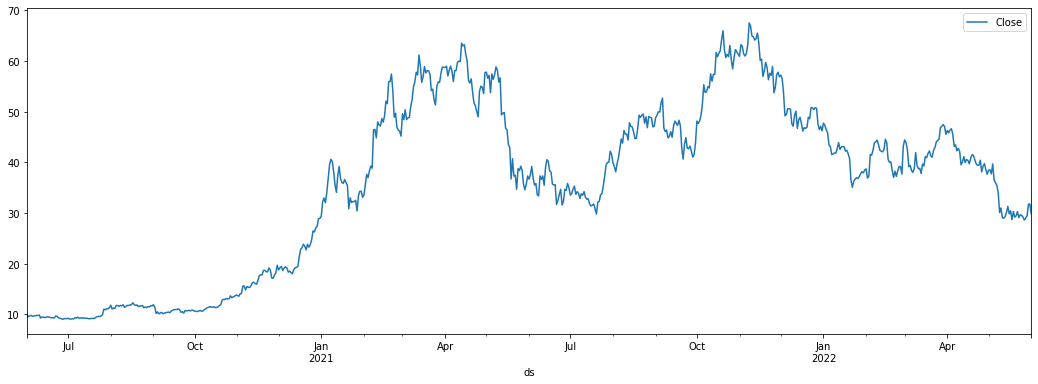

In [81]:
df.plot(x="ds", y='y',figsize=(18,6), label="Close")

<li>Ta xây dựng mô hình thông qua hàm Prophet()

In [82]:
interrupt = len(train)
interrupt

585

In [83]:
# Check size
print(train.shape)  
print(test.shape)  

(585, 2)
(146, 2)


In [84]:
future = df.copy()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


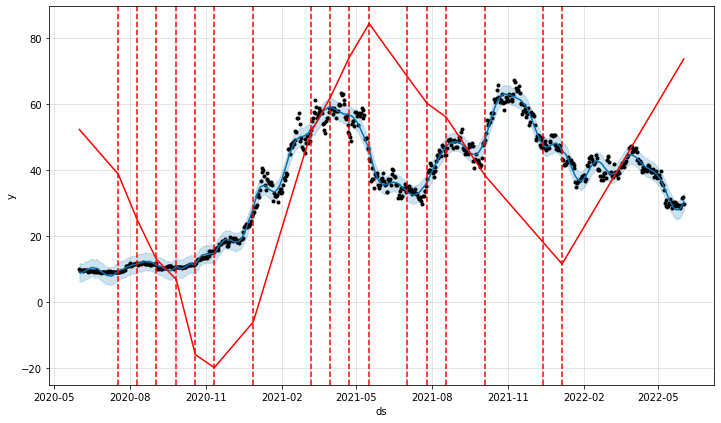

In [85]:
m = Prophet(changepoint_prior_scale=.99)
forecast = m.fit(df).predict(future)
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

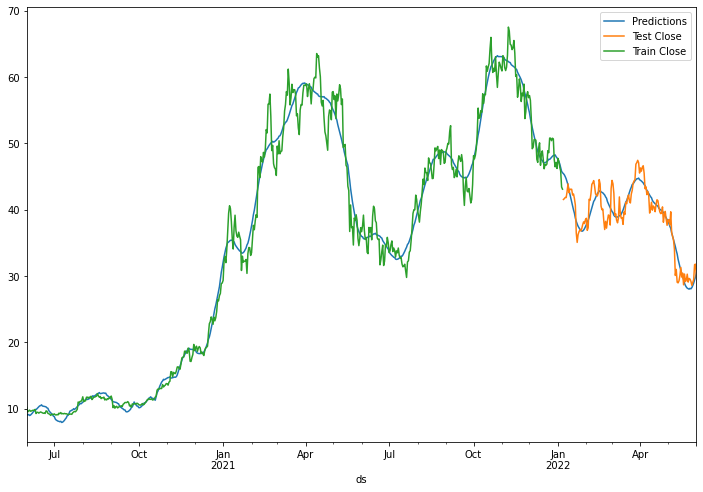

In [86]:
ax = forecast.plot(x='ds',y='yhat',label='Predictions',legend=True,figsize=(12,8))
test.plot(x='ds',y='y',label='Test Close',legend=True,ax=ax)
train.plot(x='ds',y='y',label='Train Close',legend=True,ax=ax)
#,xlim=((datetime.strptime(current_time, '%Y-%m-%d') - timedelta(days = 30)).strftime("%Y-%m-%d"),current_time)

In [87]:
mae = mean_absolute_error(test.y, forecast[interrupt:].yhat)
mape = mean_absolute_percentage_error(test.y, forecast[interrupt:].yhat)
mse = mean_squared_error(test.y, forecast[interrupt:].yhat)
rmse = np.sqrt(mse)
r2 = r2_score(test.y, forecast[interrupt:].yhat)
# print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape*100:.2f}%")
# print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAPE: 3.79%
RMSE: 1.89
R2: 0.85
